In [ ]:
%pip install numpy pandas Pillow

In [1]:
from sys import platform
import subprocess

# if the platform is Mac OS X, install the nightly build of PyTorch
if platform == "darwin":
  print("Installing nightly build of PyTorch for Mac OS X")
  # %pip install --pre torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/nightly/cpu
  subprocess.run(["pip", "install", "--pre", "torch", "torchvision", "torchaudio", "--extra-index-url", "https://download.pytorch.org/whl/nightly/cpu"])
else:
  print("Installing PyTorch for Linux")
  # %pip install torch torchvision torchaudio
  subprocess.run(["pip", "install", "torch", "torchvision", "torchaudio"])


Installing PyTorch for Linux


In [2]:
import torch
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as T
import torch.nn as nn
import torch.optim as optim
from torchvision.utils import make_grid
from torchvision.utils import save_image
import numpy as np
from IPython.display import Image
import random
from PIL import Image

In [3]:
# Use GPU if it exists - for faster execution
# Device selection for PyTorch
device = torch.device("cpu")

# Device selection for PyTorch
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print('Using GPU')
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print('Using MPS')
else:
    device = torch.device("cpu")
    print('Using CPU')

device

Using GPU


device(type='cuda', index=0)

In [4]:
# Download the dataset and unzip - RUN ONLY ONCE!
zip_file_url = "https://austons-ml-bucket.s3.fr-par.scw.cloud/cats_and_dogs_filtered.zip"
import requests, zipfile, io

# r = requests.get(zip_file_url)
# z = zipfile.ZipFile(io.BytesIO(r.content))
# z.extractall("./data/")

In [5]:
# Import all the images into the memory
# Lets check how many files are in the dataset
import os
from typing import List

train_dataset_path = "./data/cats_and_dogs_filtered/train/"
validation_dataset_path = "./data/cats_and_dogs_filtered/validation/"


def getAllFiles(categories: List[str], data_root: str, includeFileData=False) -> dict:
  filesByCategory = {}

  for category in categories:
    count = 0
    full_path = train_dataset_path + category + "s"

    for file_name in os.listdir(full_path): 
      count+=1
      file_path = full_path + "/" + file_name
      file = {
        "file_name": file_name,
        "file_path": file_path,
        "data": None
      }
      
      if includeFileData:
        with Image.open(file_path) as im:
          file["data"] = im
        
      if category in filesByCategory.keys():
        filesByCategory[category].append(file)
      else:
        filesByCategory[category] = [file]

    print(f"Total {category} images: {count}")
  return filesByCategory
    
classes = ["cat", "dog"]
filesByCategory = getAllFiles(classes, train_dataset_path)


Total cat images: 1000
Total dog images: 1000


------cat!----
(349, 262)
width:  349
height: 262


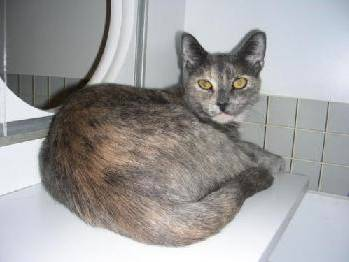

------dog!----
(432, 480)
width:  432
height: 480


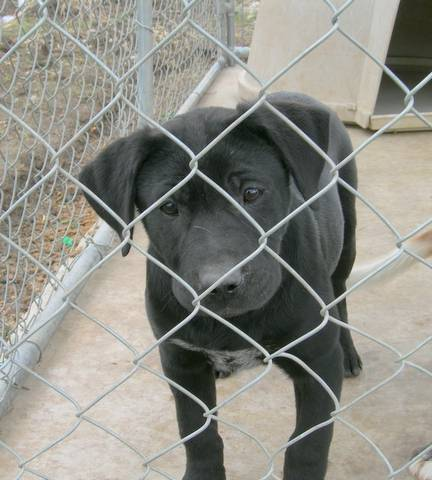

In [6]:
for category in filesByCategory:
  print(f"------{category}!----")
  file_path = filesByCategory[category][0]["file_path"]
  with Image.open(file_path) as im:
    print(im.size)
    w, h = im.size
    print('width: ', w)
    print('height:', h)
    display(im)
  

In [7]:
# Create X Train and y Train
trainingfilesByCategory = getAllFiles(classes, train_dataset_path, False)
X_train = []
y_train = []

for i in range(0, len(classes)):
  category = classes[i]
  for file in trainingfilesByCategory[category]:
    X_train.append(file["file_path"])
    y_train.append(category)
    
# Create X Validation and y Validation
validationfilesByCategory = getAllFiles(classes, validation_dataset_path, False)
X_validation = []
y_validation = []

for i in range(0, len(classes)):
  category = classes[i]
  for file in trainingfilesByCategory[category]:
    X_validation.append(file["file_path"])
    y_validation.append(category)


Total cat images: 1000
Total dog images: 1000
Total cat images: 1000
Total dog images: 1000


In [8]:
import os
import pandas as pd
from torchvision.io import read_image

torch.manual_seed(17)

class CustomImageDataset(Dataset):
    def __init__(self, img_labels, img_paths, transform=None, target_transform=None):
        self.img_labels = img_labels
        self.img_paths = img_paths
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        image = read_image(img_path)
        label = self.img_labels[idx]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label


In [9]:
batch_size = 64
image_size = 224
transform = T.Compose([
    T.ToPILImage(),
    T.Resize((image_size, image_size)),
    # T.RandomResizedCrop(image_size),
    T.RandomHorizontalFlip(),
    # T.RandomVerticalFlip(),
    T.Grayscale(),
    T.ToTensor()])



class LabelTransformer():
    labels_map = {}
    labels_id_map = {}
    
    def __init__(self, labels):
        # Create a labelMap
        labels_set = set(labels)

        for id,val in enumerate(labels_set):
            self.labels_map[val] = id
            self.labels_id_map[id] = val

    def encoder(self, label):
        return self.labels_map[label]

    def decoder(self, label_encoded):
        print(self.labels_id_map)
        return self.labels_id_map[label_encoded]
    
label_transformer = LabelTransformer(classes)  

train_dataset = CustomImageDataset(img_labels=y_train, img_paths=X_train, transform=transform, target_transform=label_transformer.encoder)
train_dl = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=0, pin_memory=True)

validation_dataset = CustomImageDataset(img_labels=y_validation, img_paths=X_validation, transform=transform, target_transform=label_transformer.encoder)
validation_dl = DataLoader(validation_dataset, batch_size, shuffle=True, num_workers=0, pin_memory=True)

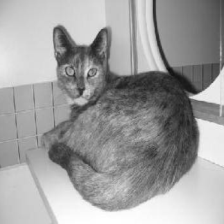

In [10]:
tensor = train_dl.dataset[0][0]
pilTransform = T.ToPILImage()
transformedImage = pilTransform(tensor)
display(transformedImage)

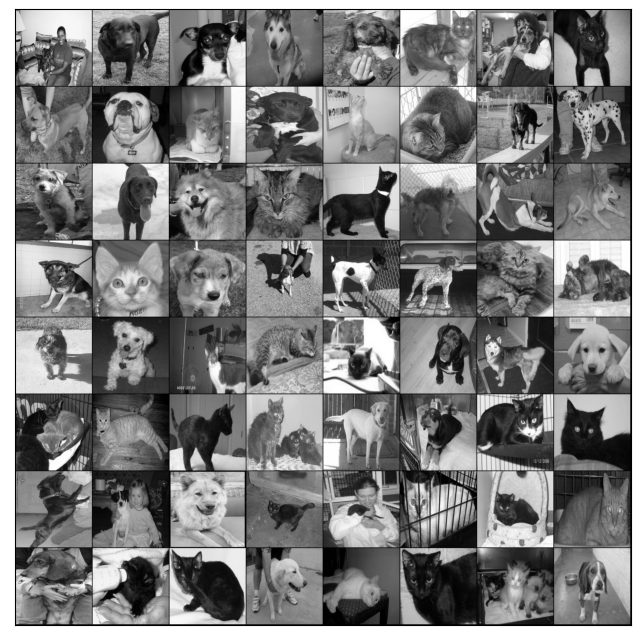

In [11]:
from matplotlib import pyplot

def show_images(images, nmax=64):
    fig, ax = pyplot.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid((images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for batch in dl:
        images, labels = batch
        show_images(images, nmax)
        break

show_batch(train_dl)

In [12]:
train_dataset[0][0].shape

torch.Size([1, 224, 224])

In [13]:
# Craete a neural network from pytorch
# https://www.kaggle.com/code/reukki/pytorch-cnn-tutorial-with-cats-and-dogs
# class Cnn(nn.Module):
#     def __init__(self):
#         super(Cnn,self).__init__()
        
#         self.layer1 = nn.Sequential(
#             nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=0, stride=2),
#             nn.BatchNorm2d(num_features=16),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2)
#         )

#         self.layer2 = nn.Sequential(
#             nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=0, stride=2),
#             nn.BatchNorm2d(num_features=32),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2)
#         )
        
#         self.layer3 = nn.Sequential(
#             nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=0, stride=2),
#             nn.BatchNorm2d(num_features=64),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2)
#         )
        
        
#         self.fc1 = nn.Linear(3*3*64,10)
#         self.dropout = nn.Dropout(0.5)
#         self.fc2 = nn.Linear(10,2)
#         self.relu = nn.ReLU()
        
        
#     def forward(self,x):
#         out = self.layer1(x)
#         out = self.layer2(out)
#         out = self.layer3(out)
#         out = out.view(out.size(0),-1)
#         out = self.fc1(out)
#         out = self.relu(out)
#         out = self.fc2(out)
#         return out

In [14]:
# Craete a neural network from pytorch
# https://www.kaggle.com/code/reukki/pytorch-cnn-tutorial-with-cats-and-dogs
class Cnn(nn.Module):
    def __init__(self):
        super(Cnn,self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=0, stride=2),
            nn.BatchNorm2d(num_features=16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=0, stride=2),
            nn.BatchNorm2d(num_features=32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=0, stride=2),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        
        self.fc1 = nn.Linear(3*3*64,10)
        # self.fc1 = nn.Linear(3*3*16, 10)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(10, 2)
        self.relu = nn.ReLU()
        
        
    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        return out

In [15]:
model = Cnn().to(device)
# model = Cnn()
model.train()

Cnn(
  (layer1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=576, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=10, out_features=2, bias=True)
  (re

In [16]:
optimizer = optim.Adam(params = model.parameters(),lr=0.001)
criterion = nn.CrossEntropyLoss()

In [ ]:
import time


def validateModel(model, dataloader, criterion, epoch):
    with torch.no_grad():
        t0 = time.time()
        
        epoch_val_accuracy=0
        epoch_val_loss=0

        for data, label in dataloader:
            data = data.to(device)
            label = label.to(device)
            
            val_output = model(data)
            val_loss = criterion(val_output,label)
            # Since optimizer isnt run here, we are not trainin the model, we will just check
            # the accuracy!
            
            acc = ((val_output.argmax(dim=1) == label).float().mean())
            epoch_val_accuracy += acc/ len(dataloader)
            epoch_val_loss += val_loss/ len(dataloader)
            
        t1 = time.time()
        print('Epoch : {}, val_accuracy : {}, val_loss : {}, time taken : {}'.format(epoch+1, epoch_val_accuracy, epoch_val_loss, t1 - t0))
        return epoch_val_accuracy, epoch_val_loss

def trainModel(model, dataloader, optimizer, criterion, epoch):
    
    t0 = time.time()
    epoch_loss = 0
    epoch_accuracy = 0
    
    for data, label in train_dl:
        data = data.to(device)
        label = label.to(device)
        
        # Get the output and loss
        output = model(data)
        loss = criterion(output, label)
        
        # Optimize the weights
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        
        # Check for Accuracy
        acc = ((output.argmax(dim=1) == label).float().mean())
        epoch_accuracy += acc/len(dataloader)
        epoch_loss += loss/len(dataloader)
    
    t1 = time.time()
    
    print('Epoch : {}, train accuracy : {}, train loss : {}, time taken : {}'.format(epoch+1, epoch_accuracy, epoch_loss, t1 - t0))
    return epoch_accuracy, epoch_loss 

        
# ----- EPOCH Training----
epochs = 50
train_acc_loss = []
val_acc_loss = []

for epoch in range(epochs):
    
    acc, loss = trainModel(model=model, dataloader=train_dl, criterion=criterion, optimizer=optimizer, epoch=epoch)
    train_acc_loss.append((acc.item(), loss.item()))

    acc, loss = validateModel(model=model, dataloader=validation_dl, criterion=criterion, epoch=epoch)
    val_acc_loss.append((acc.item(), loss.item()))

Epoch : 1, train accuracy : 0.5966796875, train loss : 0.6638643741607666, time taken : 7.81896185874939
Epoch : 1, val_accuracy : 0.64208984375, val_loss : 0.6280964016914368, time taken : 5.238369464874268
Epoch : 2, train accuracy : 0.65625, train loss : 0.615127682685852, time taken : 5.12018084526062
Epoch : 2, val_accuracy : 0.68701171875, val_loss : 0.5823583006858826, time taken : 4.6099138259887695
Epoch : 3, train accuracy : 0.7255859375, train loss : 0.5633915066719055, time taken : 4.743890047073364
Epoch : 3, val_accuracy : 0.75537109375, val_loss : 0.515044629573822, time taken : 4.736406087875366
Epoch : 4, train accuracy : 0.76416015625, train loss : 0.4992956519126892, time taken : 4.937981367111206
Epoch : 4, val_accuracy : 0.7880859375, val_loss : 0.47029730677604675, time taken : 4.866985559463501
Epoch : 5, train accuracy : 0.791015625, train loss : 0.4702989459037781, time taken : 5.007561445236206
Epoch : 5, val_accuracy : 0.7724609375, val_loss : 0.4771517813205

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

# Create a plot for accuracy against each epoch
fig, ax = plt.subplots()
# Train Accuracy per epoch
y = [acc for acc, loss in train_acc_loss]
x = np.arange(len(y))
ax.plot(x, y, color='g', label='training Accuracy')

# Train loss per epoch
y = [loss for acc, loss in val_acc_loss]
ax.plot(x, y, color='r', label='training loss')


# Validation Accuracy per epoch
y = [acc for acc, loss in val_acc_loss]
ax.plot(x, y, color='b', label='validation accuracy')

# Validation loss per epoch
y = [loss for acc, loss in val_acc_loss]
ax.plot(x, y, color='y', label='validation loss')

ax.set(title="Accuracy vs Epoch", 
      ylabel="accuracy/loss", xlabel="Epoch");

# Adding legend, which helps us recognize the curve according to it's color
ax.legend();

In [ ]:

# Print model's state_dict
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

# Print optimizer's state_dict
print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])

## Inferencing!

In [ ]:
# Save the model state
torch.save(model.state_dict(), './model-state.pth')

In [ ]:
# Load the model
new_model = Cnn()
new_model.load_state_dict(torch.load(
        "./model-state.pth", map_location=torch.device('cpu')))

In [ ]:
# url="https://images.pexels.com/photos/45201/kitty-cat-kitten-pet-45201.jpeg"
# url="https://images.pexels.com/photos/2023384/pexels-photo-2023384.jpeg"
url="https://cdn.pixabay.com/photo/2017/06/20/22/14/man-2425121_960_720.jpg"
from PIL import Image
import requests
from io import BytesIO

response = requests.get(url)
img = Image.open(BytesIO(response.content))
# display(img)

image_size = 224
# Transform this image
transform = T.Compose([
    # T.ToPILImage(),
    T.Resize((image_size, image_size)),
    T.Grayscale(),
    # T.ToTensor()
])

# inference this image
print("Transformed Image")
transformed_img = transform(img)
display(transformed_img)

transformed_img_tensor = T.ToTensor()(transformed_img)

print("Tensor -> PIL Image")
img_n = T.ToPILImage()(transformed_img_tensor)
display(img_n)
# Inference this
new_model.eval()

print(transformed_img_tensor.size())
transformed_img_tensor_unsqueezed = transformed_img_tensor.unsqueeze(0)
print(transformed_img_tensor_unsqueezed.size())


output = new_model(transformed_img_tensor_unsqueezed)
output_class_id = np.argmax(output.detach().numpy())
print("output_class_id", output_class_id)
print("output_class:", label_transformer.decoder(output_class_id))

In [ ]:
import torch.nn.functional as F
_, pred = torch.max(output, dim=1)
pred
output

In [ ]:
import urllib.request

from PIL import Image

urllib.request.urlretrieve(
  'https://media.geeksforgeeks.org/wp-content/uploads/20210318103632/gfg-300x300.png',
   "gfg.png")
  
img = Image.open("gfg.png")
display(img)

In [ ]:
from PIL import Image
import requests
from io import BytesIO

url = "https://media.geeksforgeeks.org/wp-content/uploads/20210318103632/gfg-300x300.png"
response = requests.get(url)
img = Image.open(BytesIO(response.content))
display(img)